Diabetes-Related Gene Expression Signatures in Kidney Transplant Rejection
------------------------------------------------------------
The objective of this project is to investigate whether kidney transplant rejection
is associated with the expression of diabetes-related genes. By analyzing publicly
available transcriptomic datasets, the aim is to identify potential molecular patterns
that link transplant outcomes with genes involved in diabetes pathways.

------------------------------------------------------------
Requirements and Data Download
------------------------------------------------------------
Before running this script, make sure that the required Python libraries are installed.
The main libraries used in this analysis are:
- pandas, numpy, pathlib, gzip, shutil (for data handling and preprocessing)
- scikit-learn (for machine learning models, preprocessing, evaluation)
- matplotlib (for visualization)
- scipy (for statistical tests)

It is possible to install them using pip, for example:
pip install pandas numpy scikit-learn matplotlib scipy

In addition, it is mandatory to download the following GEO dataset files:
- "GSE49198_sample_metadata_sheet.xls.gz"
- "GSE49198_virtual_platform_and_normalized_data.txt.gz"
from the GEO database at:
https://api-www-ncbi.laibokeji.com/geo/query/acc.cgi?acc=GSE49198
This dataset is associated with the publication:
Kidney Int 2015 May;87(5):984-95

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import gzip
import shutil
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve

In [2]:
DATA_DIR = Path("")  # <-- the path for SE49198_sample_metadata_sheet.xls.gz and GSE49198_virtual_platform_and_normalized_data.txt.gz
META_XLS_GZ = DATA_DIR / "GSE49198_sample_metadata_sheet.xls.gz"
META_XLS = META_XLS_GZ.with_suffix('')

EXPR_TXT_GZ = DATA_DIR / "GSE49198_virtual_platform_and_normalized_data.txt.gz"

------------------------------------------------------------
Load sample metadata
------------------------------------------------------------
This step focuses on preparing the metadata associated with the samples.
The metadata provides contextual information such as sample identifiers,
experimental groups, and study origin. These details are essential to correctly
link gene expression data with biological and clinical annotations.

In [3]:
# One-time decompression of the metadata file (.xls.gz → .xls)
with gzip.open(META_XLS_GZ, "rb") as f_in:
    with open(META_XLS, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the Excel metadata file.
# If the file format is old (.xls), engine="xlrd" is required.
# For newer .xlsx formats, engine="openpyxl" should be used instead.
meta = pd.read_excel(META_XLS, engine="xlrd", header=3)
meta.head()

# Normalize column names by removing extra spaces.
meta.columns = [str(c).strip() for c in meta.columns]

# Retain only the first 596 rows, discarding entries without valid samples.
meta = meta.iloc[:596:, :]

# Ensure that the column "Sample name" exists, otherwise raise an error.
if "Sample name" not in meta.columns:
    raise ValueError("Nel metadata non trovo la colonna 'Sample name'. Controlla i nomi delle colonne del tuo file.")


# Create a categorical variable 'group' based on the prefix of the sample ID.
# Groups correspond to experimental conditions or patient categories:
meta = meta.rename(columns={"Sample name": "sample_id"})
meta["group"] = meta["sample_id"].astype(str).map(
    lambda sid: next((k for k in ["HV","TOL","MIS","STA","CR","AR"] if sid.upper().startswith(k)), "NA")
)

# Rename study/batch related columns for clarity.
meta = meta.rename(columns={"characteristics: Study of origin": "n_GSE", "characteristics: GSE of origin": "study_GSE"})

# Keep only the essential columns required for downstream analyses.
meta = meta[["sample_id", "group", "n_GSE", "study_GSE"]]

------------------------------------------------------------
Load expression matrix
------------------------------------------------------------
This step loads the normalized gene expression matrix from GEO.
The file contains both gene annotations and expression values for each sample.
The objective is to extract the numeric expression data, handle missing values,
and transform the dataset into a standard samples × genes structure.

In [4]:
# Identify which columns correspond to samples by excluding annotation columns.
expr_raw = pd.read_csv(
    EXPR_TXT_GZ,
    sep="\t",
    compression="gzip",
    comment="#",
    dtype=str,
    header=2
)

# Identifica colonne di annotazione gene
sample_cols = [c for c in expr_raw.columns if c not in ["ID_REF","Probe_Name","Probe_Description","Name","Synonyms",
              "Unigene","EntrezGene_ID","RefSeq","Uniprot","ENSG","ENST"]]

if len(sample_cols) == 0:
    raise ValueError("Non ho trovato colonne campione nella matrice di espressione. Controlla il file .txt.gz.")
    
# Extract expression data containing only sample-level values.
expr = expr_raw[sample_cols].copy()

# Convert expression values to numeric. Non-numeric entries are coerced to NaN.
for c in expr.columns.drop("Symbol"):
    expr[c] = pd.to_numeric(expr[c], errors="coerce")
    
# Transpose the matrix to obtain samples × genes format.
# After transposition, reset the index and fix column names.
genes = expr.T.copy()
genes = genes.reset_index() 
genes.columns = genes.iloc[0]  
genes = genes.drop(0)
genes = genes.reset_index(drop=True)
genes = genes.rename(columns={"Symbol": "sample_id"})

------------------------------------------------------------
Align metadata with gene expression and select diabetes-related candidate genes
------------------------------------------------------------
In this section, the gene expression data are aligned with the sample metadata, ensuring
that each patient/sample has corresponding clinical group labels.
The number and type of features (genes) included in the model were defined exclusively based on domain knowledge, 
namely prior evidence on genes implicated in diabetes susceptibility, given the established association 
between post-transplant diabetes mellitus and adverse transplant outcomes (https://doi.org/10.3390/genes14081595, https://doi.org/10.2337/diacare.27.3.805).
Feature selection is therefore knowledge-driven (based on prior evidence and published studies) rather than automated; this choice improves interpretability, reduces overfitting risk, and ensures clinical plausibility in small datasets (https://doi.org/10.1371/journal.pone.0318874).

HLA-DQA1 -> https://doi.org/10.2337/db07-1331 <br>
HLA-DQB1 -> https://doi.org/10.2337/db07-1331 <br>
CTLA4 -> https://doi.org/10.1093/aje/kwi165 <br>
IL2RA -> https://pubmed.ncbi.nlm.nih.gov/15776395/ <br>
HHEX -> https://doi.org/10.1002/jcb.28788 <br>
DPP4 -> https://pubmed.ncbi.nlm.nih.gov/27111895/ <br>
ABCA1 -> https://doi.org/10.2337/db07-0484 <br>
INSR  -> https://doi.org/10.2337/diacare.13.3.257 <br>
RCAN1 -> https://doi.org/10.1210/en.2011-2149 <br>
CDKAL1 -> https://doi.org/10.3389/fgene.2021.783078 <br>
PPARG -> https://doi.org/10.1172/JCI23586 <br>
PPARGC1A -> https://doi.org/10.1007/s00125-005-0130-2 <br>
SH2B3 -> https://doi.org/10.1093/hmg/ddae024 <br>
IKZF1 -> https://doi.org/10.1016/j.diabres.2015.01.022 <br>
VDR -> https://doi.org/10.1016/j.numecd.2016.02.004

In [5]:
# Merge gene expression data with metadata to keep only aligned samples
# (inner join ensures only samples present in both tables are included)
dataframe = pd.merge(genes, meta[["sample_id", "group"]], on="sample_id", how="inner")

# Curated list of candidate genes for diabetes susceptibility, selected from literature
# These will be used as predictive features in the classification model
diabete_candidate_genes = [
    "HLA-DQA1", "HLA-DQB1", "CTLA4", "IL2RA", "HHEX", "DPP4",
    "ABCA1", "INSR", "RCAN1", "CDKAL1", "PPARG", "PPARGC1A",
    "SH2B3", "IKZF1", "VDR"
]

# Subset the merged dataframe to keep only sample identifiers, selected genes, and group labels
dataframe_diabetes_genes = dataframe[["sample_id"] + diabete_candidate_genes + ["group"]]

In [6]:
# Define feature matrix (X) and target vector (y)
X_features = dataframe_diabetes_genes.drop(columns=["sample_id", "group"])
y_target = dataframe_diabetes_genes["group"]

Map the multiclass group labels into a binary classification task:
- CR (Chronic Rejection) and AR (Acute Rejection) → 1 (high risk)
- TOL (Tolerant patients) → 0 (low risk)
- MIS, STA, HV → excluded (set as NaN)
Group definitions:
HV = Healthy Volunteers (healthy controls)
TOL = Tolerant patients (no chronic immunosuppression required)
MIS = Minimal Immunosuppression (minimal therapy required)
STA = Stable (on standard immunosuppression)
CR = Chronic Rejection (long-term transplant failure)
AR = Acute Rejection (acute transplant rejection episode)

In [7]:
def to_risk(g):
    if pd.isna(g):
        return np.nan
    g = str(g).upper()
    if g in ["CR", "AR"]:
        return 1
    if g in ["TOL"]:
        return 0
    return np.nan  # MIS / STA / HV are excluded


# 1) Apply mapping from group labels to binary rejection risk
y_target_bin = y_target.map(to_risk)

# 2) Identify valid indices by excluding NaN values
valid_idx = y_target_bin.dropna().index

# 3) Filter the feature matrix and binary labels to include only valid samples
X_features_bin = X_features.loc[valid_idx].copy()
y_target_bin = y_target_bin.loc[valid_idx].astype(int)  # cast a interi 0/1


# Print summary statistics: dataset shapes and distribution of target labels
print("Shape of X (original):", X_features.shape)
print("Shape of X (filtered):", X_features_bin.shape)
print("Distribution of y:", y_target_bin.value_counts(), sep="\n")

Shape of X (original): (596, 15)
Shape of X (filtered): (191, 15)
Distribution of y:
0    96
1    95
Name: group, dtype: int64


------------------------------------------------------------
Exploratory Statistical Analysis (Mann–Whitney U tests)
------------------------------------------------------------
In this section, the expression of each diabetes-related candidate gene is compared between
high-risk and low-risk groups for kidney transplant rejection. The approach combines
visualization (boxplots) with statistical testing (Mann–Whitney U test) to evaluate whether
differences in expression are significant. The p-values are corrected using the Bonferroni
method to account for multiple testing across all genes. This analysis highlights which
genes are most strongly associated with the risk of rejection.

The Mann–Whitney U test was specifically chosen because Shapiro–Wilk tests indicated non-normal 
distribution of the samples, making non-parametric methods more appropriate.

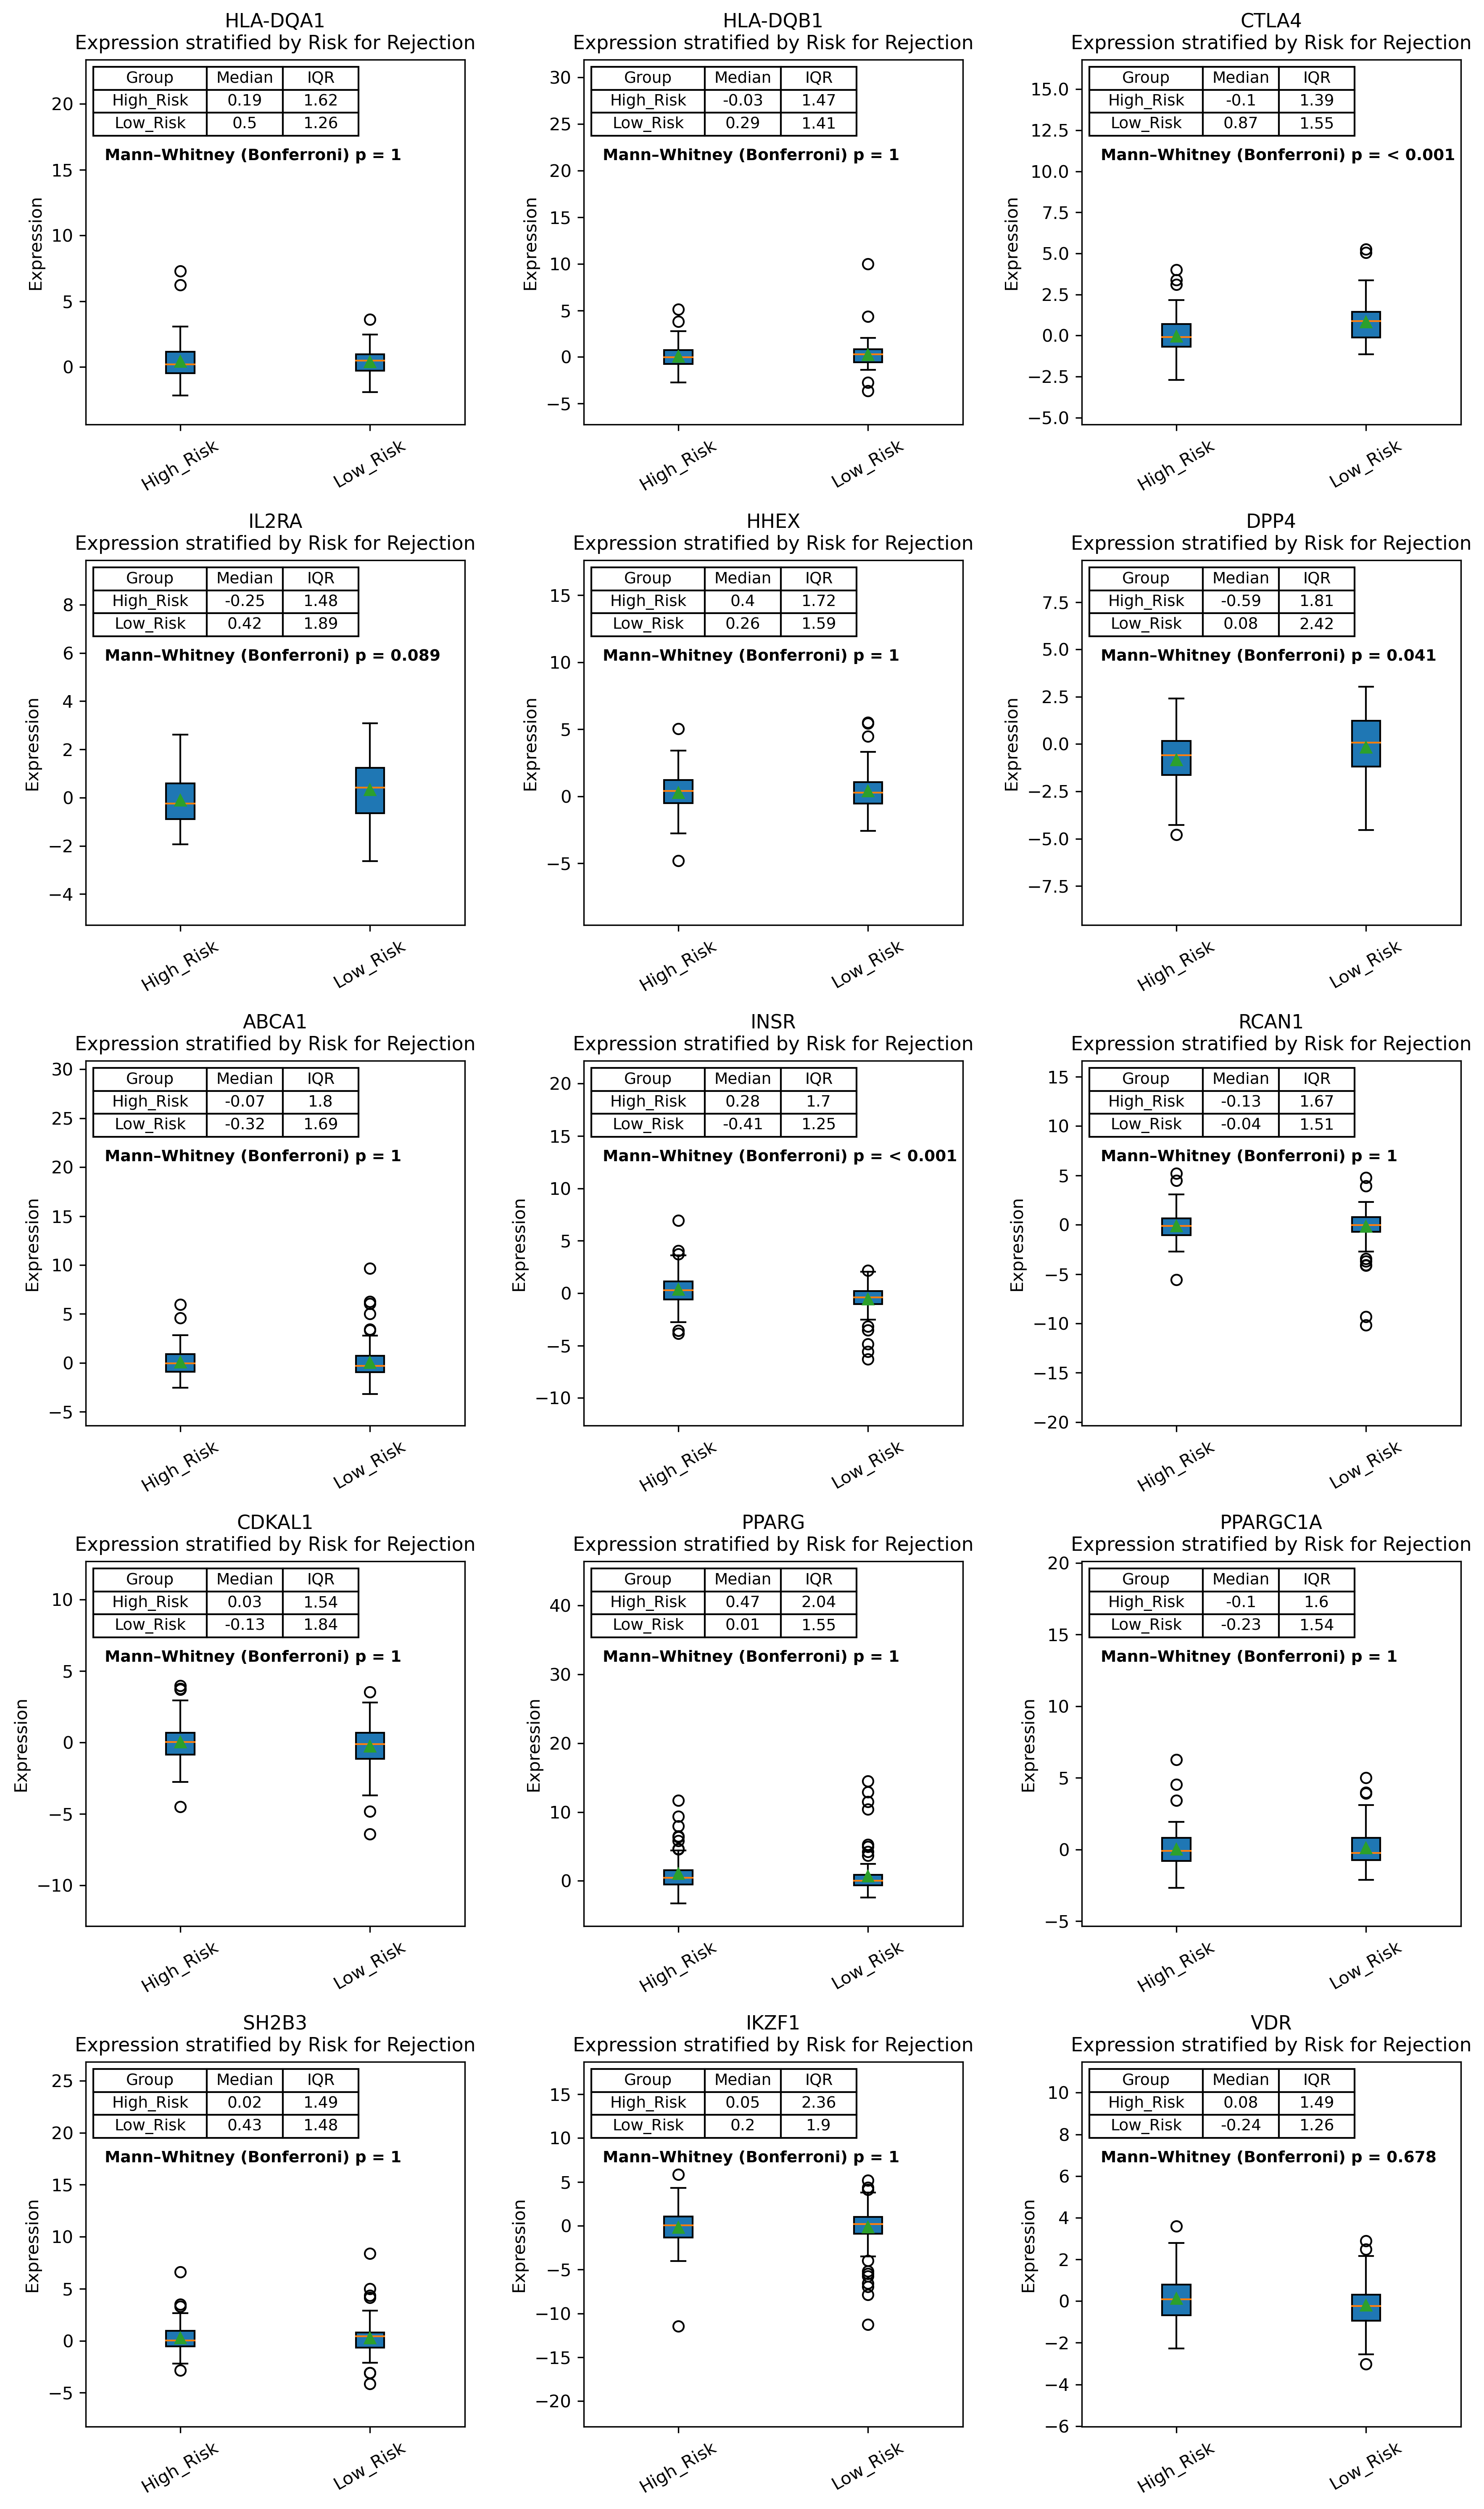

In [8]:
# Build dataframe combining expression features with binary target labels
histogram_df = pd.concat([X_features_bin, y_target_bin], axis=1)

# Candidate genes under investigation
genes = [
    "HLA-DQA1", "HLA-DQB1", "CTLA4", "IL2RA", "HHEX", "DPP4",
    "ABCA1", "INSR", "RCAN1", "CDKAL1", "PPARG", "PPARGC1A",
    "SH2B3", "IKZF1", "VDR"
]

# Compute grid size for subplots based on the number of genes
ncols = 3
nrows = int(np.ceil(len(genes) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4), dpi=300)
axes = axes.flatten()

for idx, gene in enumerate(genes):
    # Ensure values are numeric
    histogram_df[gene] = pd.to_numeric(histogram_df[gene], errors="coerce")
    group1 = histogram_df[histogram_df['group'] == 1][gene]
    group0 = histogram_df[histogram_df['group'] == 0][gene]

    ax = axes[idx]
    labels = ['High_Risk', 'Low_Risk']

    # Draw boxplot comparing high- vs low-risk groups
    ax.boxplot([group1, group0], labels=labels, patch_artist=True, showmeans=True)
    ax.set_xticklabels(labels, rotation=30)
    ax.set_ylabel("Expression")
    ax.set_title(f"{gene}\nExpression stratified by Risk for Rejection", fontsize=11)
    
    # Adjust y-axis limits for better visualization
    max_value = histogram_df[gene].values.max()
    extended_max_value = max_value + (max_value * 2.2)
    min_value = histogram_df[gene].values.min()
    extended_min_value = min_value + (min_value * 1)
    ax.set_ylim(extended_min_value, extended_max_value)

    # Helper function: compute median and interquartile range
    def median_iqr(arr):
        return round(np.median(arr), 2), round(np.percentile(arr, 75) - np.percentile(arr, 25), 2)

    med1, iqr1 = median_iqr(group1)
    med0, iqr0 = median_iqr(group0)

    # Display median and IQR values as a small table
    table_data = [
        ["Group", "Median", "IQR"],
        ["High_Risk", med1, iqr1],
        ["Low_Risk",  med0, iqr0]
    ]
    ax.table(cellText=table_data, loc="upper left", cellLoc="center", colWidths=[0.3, 0.2, 0.2])

    # Perform Mann–Whitney U test and apply Bonferroni correction
    if len(group1) > 0 and len(group0) > 0:
        stat, p = mannwhitneyu(group1, group0, use_continuity=True)
        p = p * len(genes)      # correzione Bonferroni
        p = min(p, 1)         # tronca a 1 se > 1
        p_str = "< 0.001" if p < 0.001 else "1" if p == 1 else f"{p:.3f}"
        ax.text(0.05, 0.725, f"Mann–Whitney (Bonferroni) p = {p_str}", transform=ax.transAxes, fontsize=9, fontweight="bold")

# Remove empty subplots if the number of genes is not a multiple of ncols
for j in range(len(genes), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Interpretation note: In analyses on this dataset, CTLA4, DPP4, and INSR were observed as
statistically significant after Bonferroni correction for multiple testing, suggesting a
possible association with kidney transplant rejection risk.

------------------------------------------------------------
Correlation analysis among candidate genes
------------------------------------------------------------
This section evaluates the pairwise correlation among the diabetes-related
candidate genes using Spearman's rank correlation coefficient. Spearman is a
non-parametric method, chosen because it does not assume linearity or normality
of the data. A heatmap is generated to visualize the correlation matrix and to
detect possible redundancy among the features.

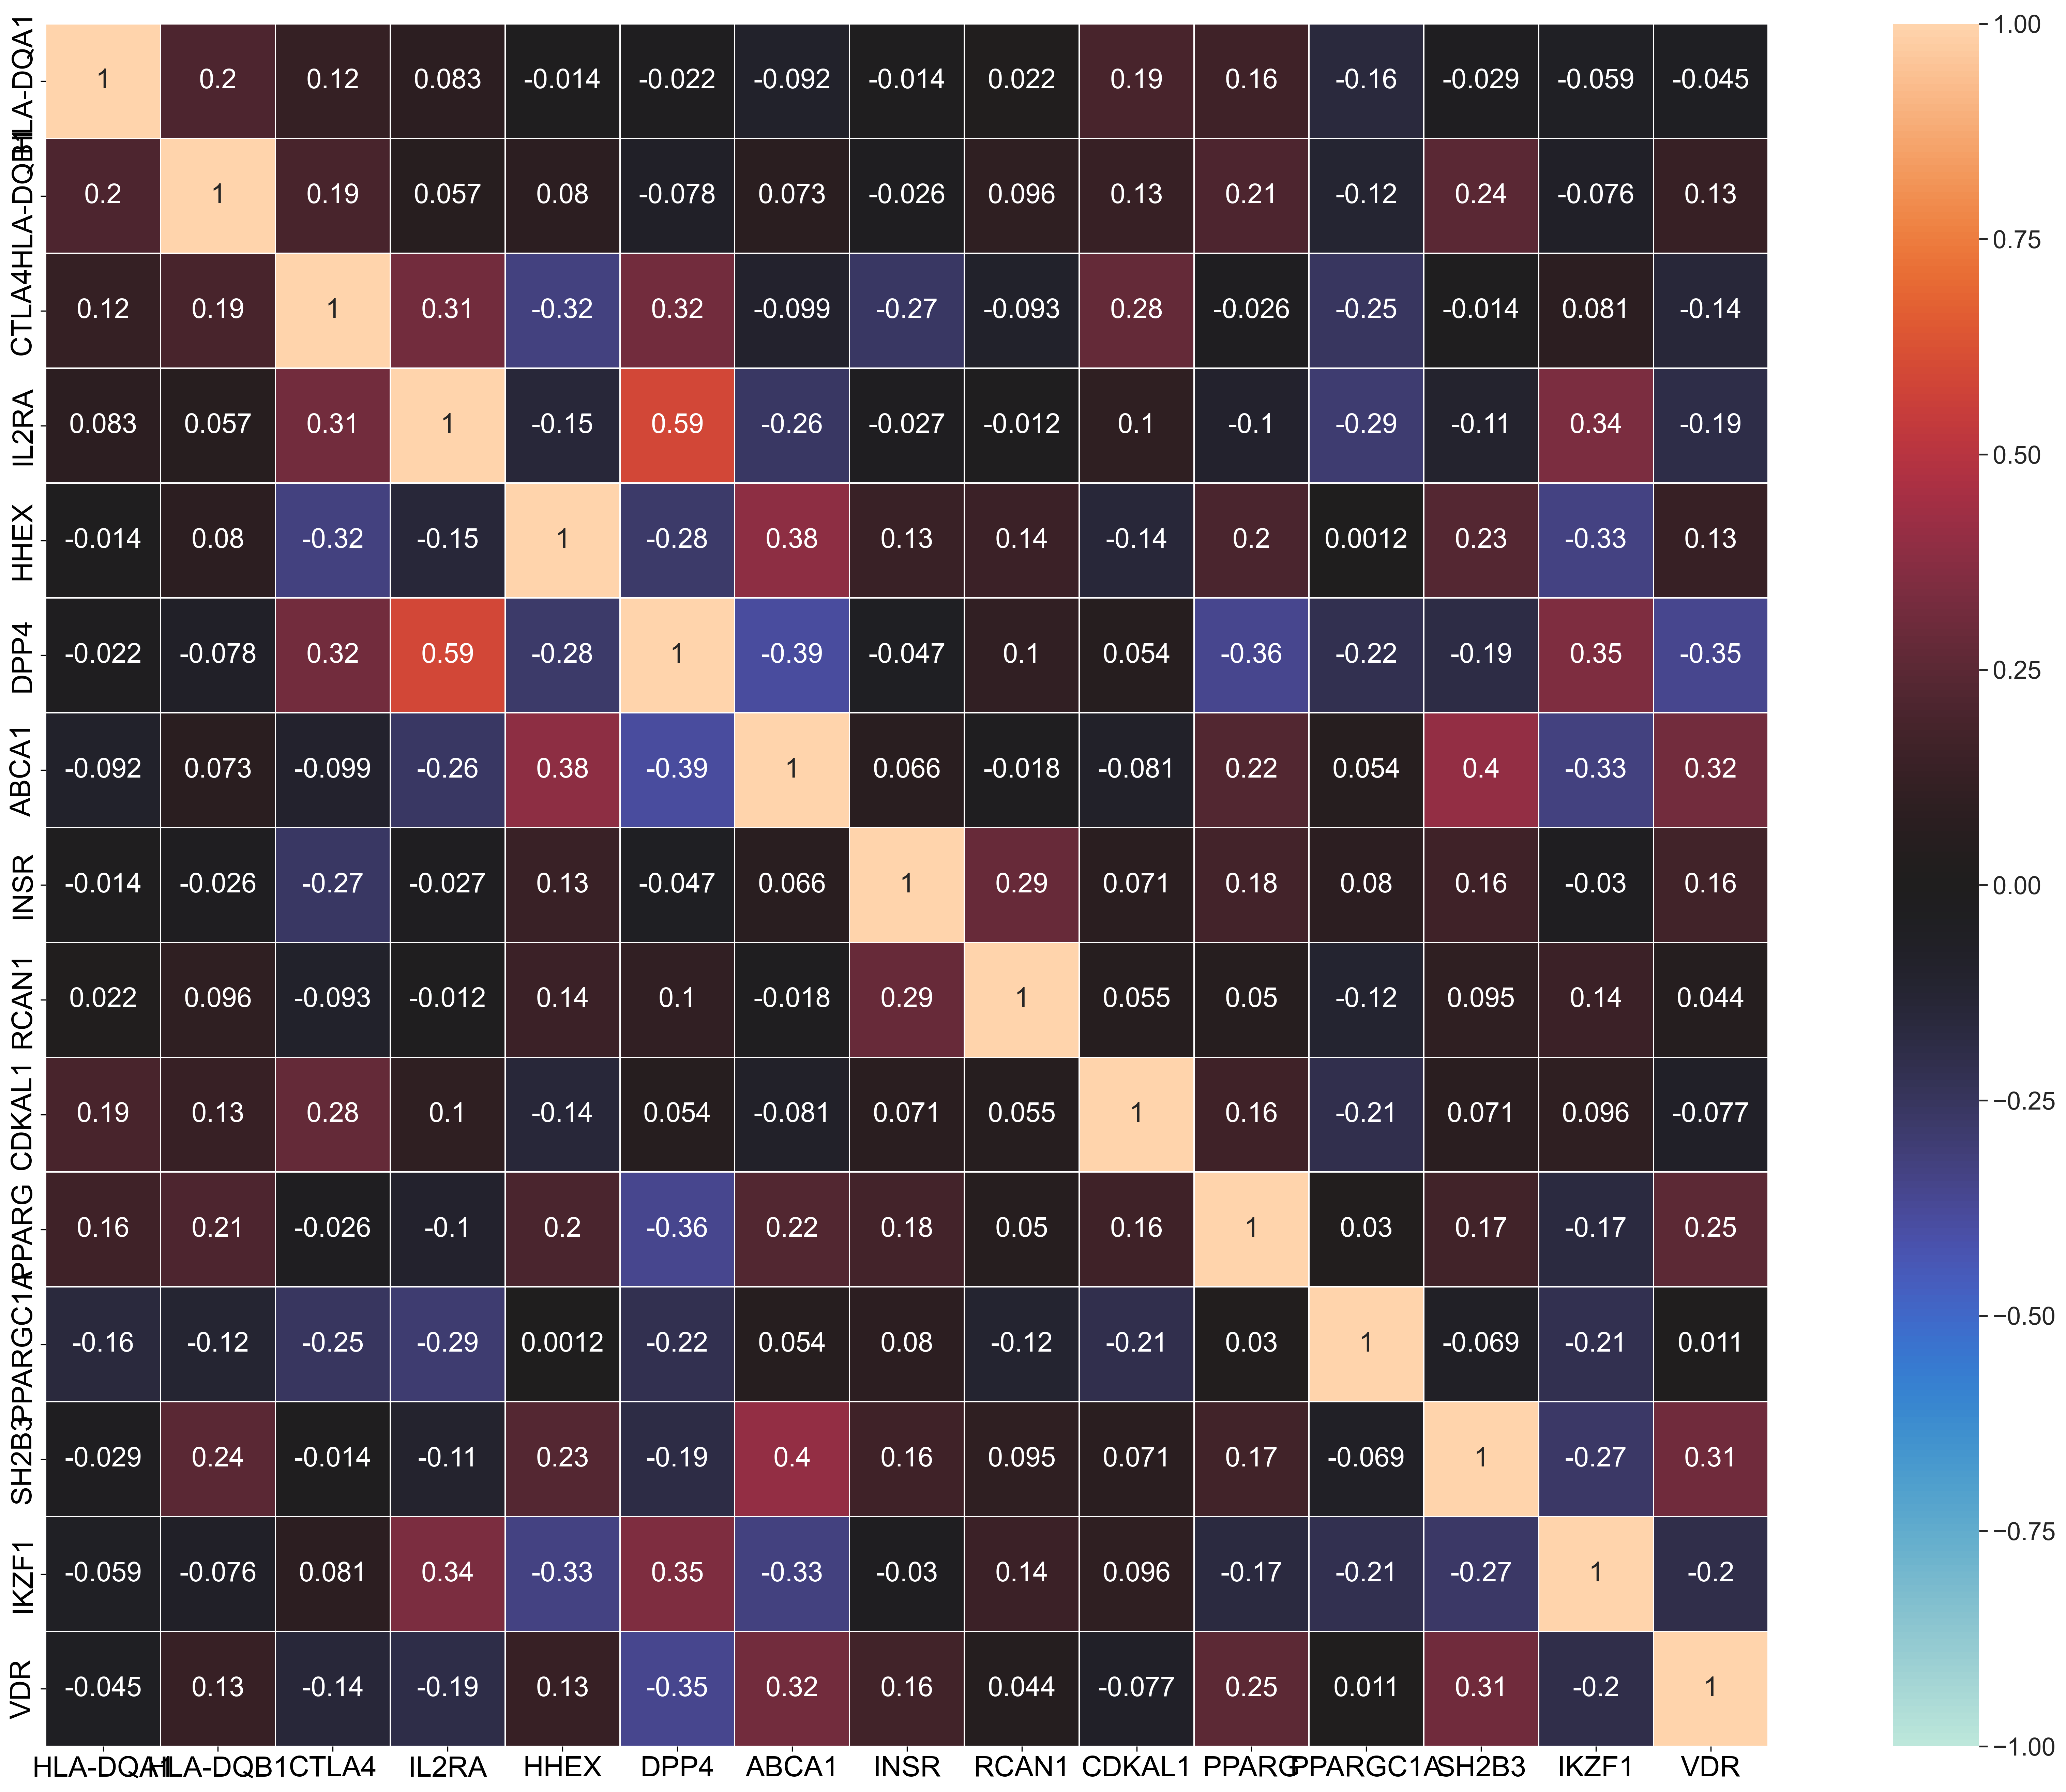

In [9]:
# Compute correlation matrix with Spearman method
corr_matrix = X_features_bin.apply(pd.to_numeric, errors="coerce").corr(method="spearman")

# Set the figure, the general plot style and font scale for seaborn
fig, ax = plt.subplots(figsize=(25, 18), dpi=300)
sns.set(font_scale=1.6)

# Draw annotated heatmap of the correlation matrix
with sns.axes_style('white'):
    ax = sns.heatmap(
        corr_matrix,
        center=0,
        annot=True,        # show correlation values in each cell
        linewidths=.5,     # thin lines between cells
        cbar=True,         # show color bar legend
        square=True,       # enforce square-shaped cells
        vmin=-1, vmax=+1,  # correlation range limits
        yticklabels=True,
        xticklabels=True
    )
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.show()

# Clear the figure to free memory after plotting
plt.clf(); plt.cla(); plt.close()

Interpretation note: The heatmap shows that there is no inter-correlation
among the selected diabetes-related genes, indicating that they provide
complementary information rather than redundant signals.

------------------------------------------------------------
KNN pipeline, repeated stratified CV, and ROC evaluation
------------------------------------------------------------
This section defines a distance-based classifier (KNN) wrapped in a Pipeline with
feature scaling and evaluates it with 10×5 repeated stratified cross-validation.
Rationale:
- StandardScaler scales each feature to zero mean and unit variance so that all genes
  contribute comparably to Euclidean distances; this is essential for KNN.
- KNeighborsClassifier with n_neighbors=7 offers a reasonable bias–variance trade-off
  on small/medium cohorts: larger k smooths noisy boundaries, while an odd k reduces ties.
  Here k=7 is chosen as a pragmatic default (e.g., after preliminary CV sweeps) that
  avoids overfitting from very small k and oversmoothing from very large k.
- RepeatedStratifiedKFold (5 folds × 10 repeats) provides more stable, lower-variance
  performance estimates than a single split, with stratification preserving class balance.
  This repeated CV setting is commonly used in medical ML to mitigate variance in small
  datasets (e.g., NeuroImage: Clinical, 2021;30:102640. https://doi.org/10.1016/j.nicl.2021.102640).

In [10]:
# Define the pipeline: standardize features THEN apply KNN (distance-based model)
pipeline = Pipeline([
    ("scaler", StandardScaler()), # fit on training folds only (no leakage)
    ("knn", KNeighborsClassifier(n_neighbors=7))
])

# Optional alternative:
# Replace KNN with a Random Forest to compare a tree-based model (scale-insensitive).
# This is purely optional for sensitivity analysis; evaluation code above remains identical.
# pipeline = Pipeline([
#     ("scaler", StandardScaler()),            # kept for parity; RF does not require scaling
#     ("rf", RandomForestClassifier(n_estimators=100, random_state=0))
# ])

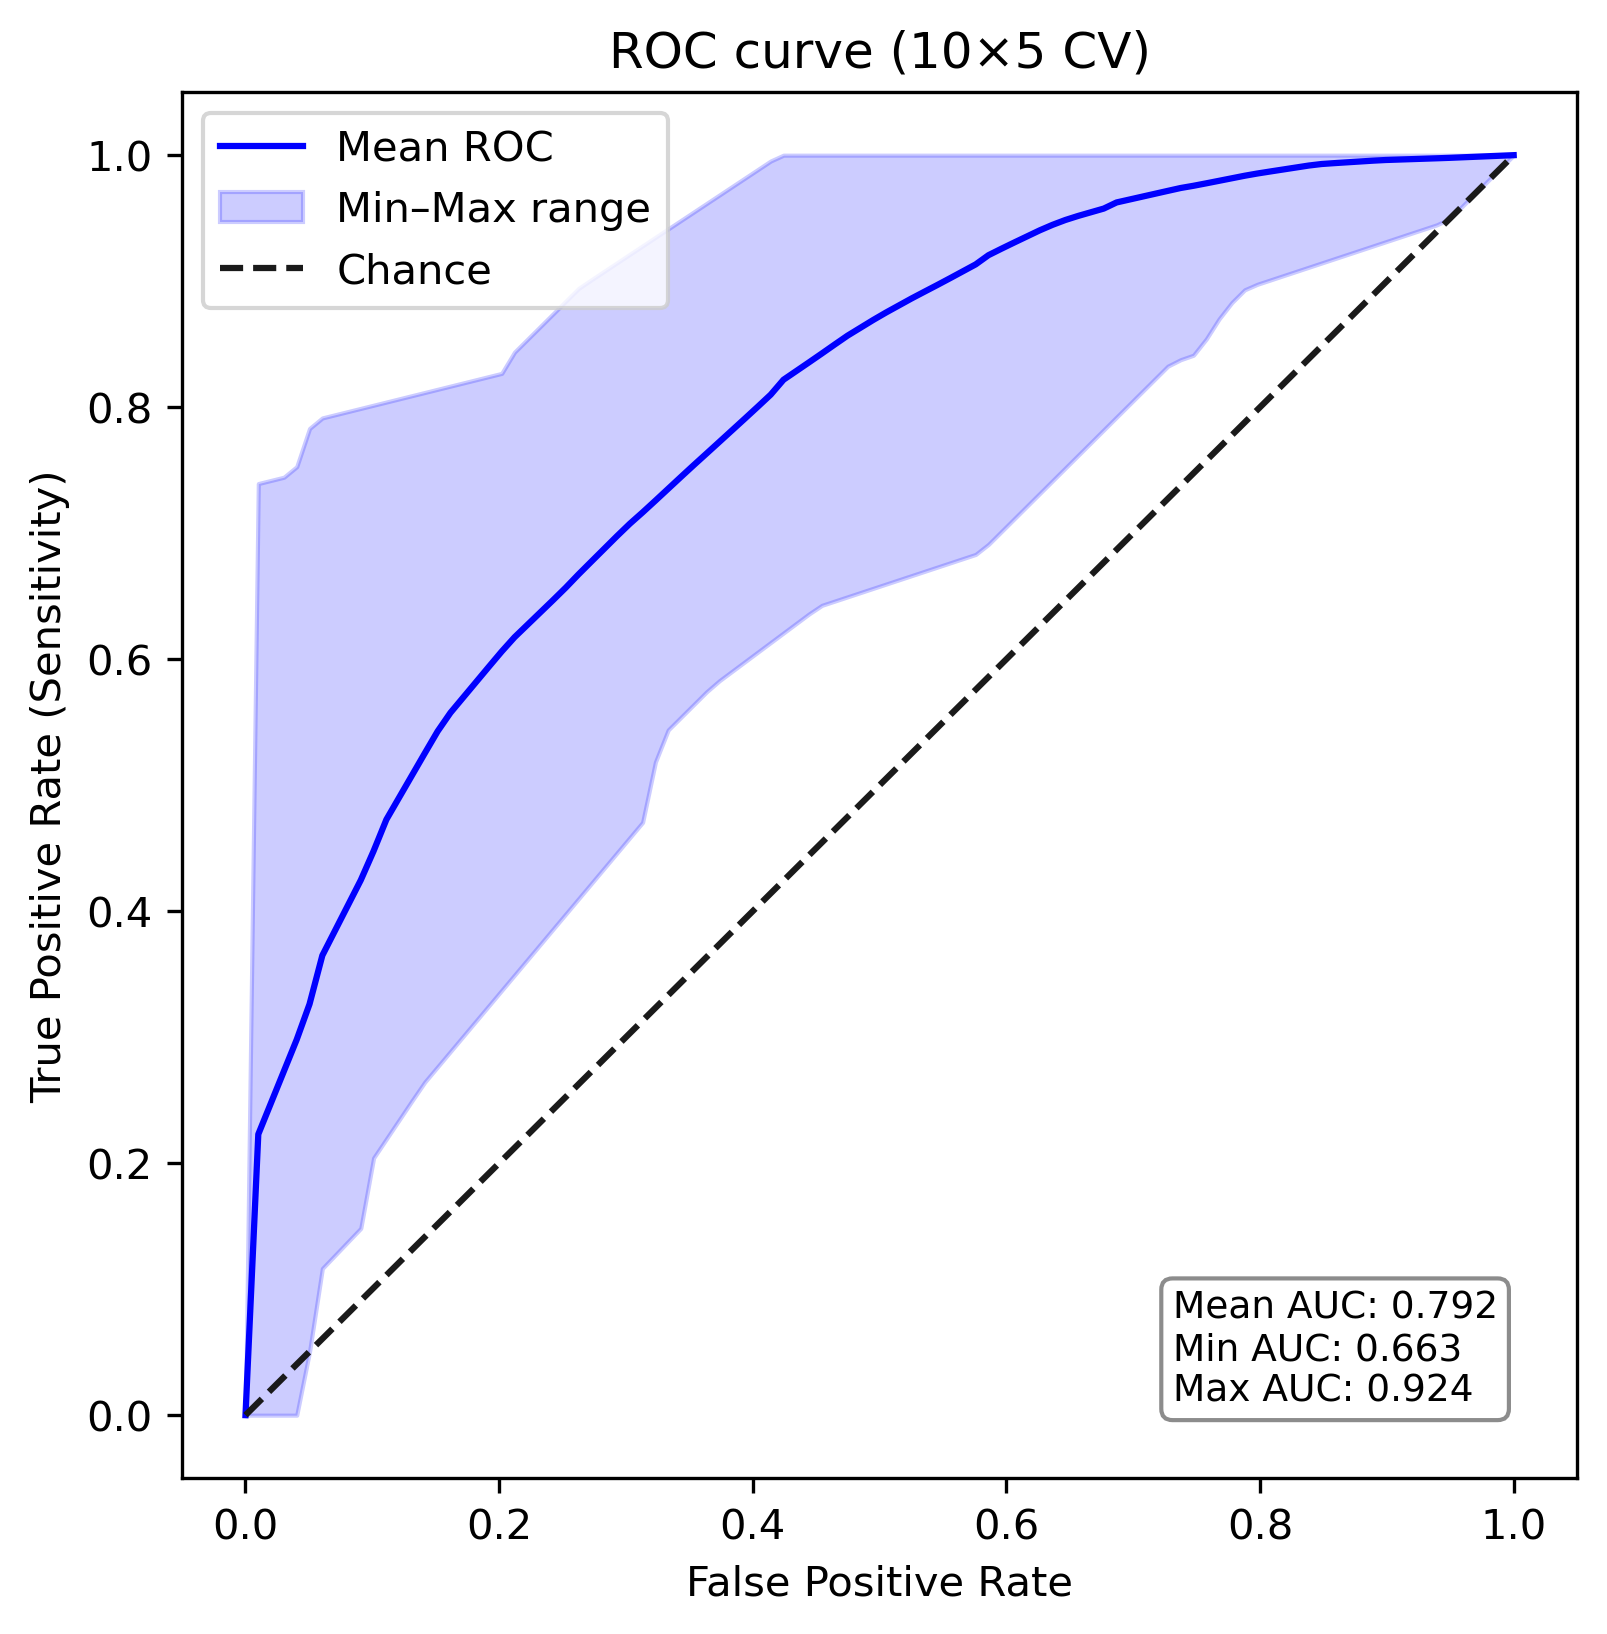

In [29]:
# Repeated stratified CV: 5 folds, repeated 10 times with fixed RNG for reproducibility
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

aucs, accs, sens, spec = [], [], [], []

# Common FPR grid for averaging ROC curves across folds/repeats
fpr_grid = np.linspace(0, 1, 100)
tprs = []

for train_idx, test_idx in cv.split(X_features_bin, y_target_bin):
    X_tr, X_te = X_features_bin.iloc[train_idx], X_features_bin.iloc[test_idx]
    y_tr, y_te = y_target_bin.iloc[train_idx], y_target_bin.iloc[test_idx]

    # Fit the whole pipeline on the training partition (scaler learns from train only)    
    pipeline.fit(X_tr, y_tr)

    # Predictions and calibrated probabilities for ROC/AUC
    y_pred = pipeline.predict(X_te)
    y_proba = pipeline.predict_proba(X_te)[:, 1]
    
    # ROC for this split; then interpolate TPRs on a common FPR grid for averaging
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    tpr_interp = np.interp(fpr_grid, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    
    # Split-wise metrics
    aucs.append(roc_auc_score(y_te, y_proba))
    accs.append(accuracy_score(y_te, y_pred))
    sens.append(recall_score(y_te, y_pred, pos_label=1))  # sensitivity (TPR)
    spec.append(recall_score(y_te, y_pred, pos_label=0))  # specificity (TNR)

# Aggregate ROC envelopes across all splits
tprs = np.array(tprs)
tpr_mean = tprs.mean(axis=0)
tpr_min = tprs.min(axis=0)
tpr_max = tprs.max(axis=0)

# AUC summary stats
auc_mean = float(np.mean(aucs))
auc_min  = float(np.min(aucs))
auc_max  = float(np.max(aucs))

# Plot mean ROC and min–max envelope
plt.style.use("default")
plt.figure(figsize=(6,6), dpi = 300)
plt.plot(fpr_grid, tpr_mean, color="blue", label="Mean ROC")
plt.fill_between(fpr_grid, tpr_min, tpr_max, color="blue", alpha=0.2,
                 label="Min–Max range")
plt.plot([0,1], [0,1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC curve (10×5 CV)")

# Text box with AUC stats
ax = plt.gca()
ax.text(
    0.71, 0.05,
    f"Mean AUC: {auc_mean:.3f}\n"
    f"Min AUC: {auc_min:.3f}\n"
    f"Max AUC: {auc_max:.3f}",
    transform=ax.transAxes,
    fontsize=9,
    va="bottom", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.9)
)

plt.legend()
plt.show()

In [12]:
def summarize(vals, pct=False):
    """Return mean (SD) [min–max]; optionally in percentage units."""
    vals = np.asarray(vals, dtype=float)
    if pct:
        vals = vals * 100.0
    m = np.mean(vals)
    sd = np.std(vals, ddof=1)
    lo, hi = np.min(vals), np.max(vals)
    if pct:
        return f"{m:.2f} ({sd:.2f}) [{lo:.2f}–{hi:.2f}]"
    else:
        return f"{m:.3f} ({sd:.3f}) [{lo:.3f}–{hi:.3f}]"

row_auc = summarize(aucs, pct=False)
row_acc = summarize(accs, pct=True)
row_sen = summarize(sens, pct=True)
row_spe = summarize(spec, pct=True)

rows = [
    ("AUC",            row_auc),
    ("Accuracy [%]",   row_acc),
    ("Sensitivity [%]",row_sen),
    ("Specificity [%]",row_spe),
]

print("Classification performance for KNN + StandardScaler.")
print("Estimated using 10-times repeated 5-fold CV (mean (SD) [range]).\n")

col1_w = 15
header1, header2 = "Metric", "Mean (SD) [range]"
print(f"{header1:<{col1_w}} {header2}")
print("-" * (col1_w + 1 + len(header2)))
for m, v in rows:
    print(f"{m:<{col1_w}} {v}")

Classification performance for KNN + StandardScaler.
Estimated using 10-times repeated 5-fold CV (mean (SD) [range]).

Metric          Mean (SD) [range]
---------------------------------
AUC             0.792 (0.067) [0.663–0.924]
Accuracy [%]    70.80 (6.76) [57.89–86.84]
Sensitivity [%] 68.74 (10.76) [47.37–89.47]
Specificity [%] 72.80 (8.56) [52.63–94.74]


------------------------------------------------------------
Conclusions
---------------------------------------------------------
The results suggest that a machine learning model (KNN with standardized features) achieves a moderate discriminative ability in distinguishing between low- and high-risk kidney transplant patients based on the expression of diabetes-related candidate genes. With an average AUC of ~0.79, the model shows promising signal.

These findings highlight the potential clinical relevance of specific diabetes-associated genes—such as CTLA4, DPP4, and INSR—in transplant rejection risk. However, the study is limited by sample size and the use of a predefined candidate-gene approach, which restricts generalizability.

Overall, this work provides proof-of-concept that molecular signatures linked to diabetes pathways may contribute to risk stratification after kidney transplantation. Future studies with larger cohorts, more comprehensive omics profiling, and independent validation will be needed to strengthen the evidence and evaluate clinical utility.